In [10]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import csv
import matplotlib.pyplot as plt
import ast 

## Adsoorption using AiiDAlab
# Question 1:

AiiDAlab provides multiple ways to study adsorption. The three main type of calculation AiiDAlab uses are: XX, XX and XX

# Question 2:




In [2]:
data = {'Probe radius[A]': [1.525] ,'Density[g/cm^3]':[0.576983], 'Accesible Surface Area[A^2]':[0.0], 'Accessible preocupable volume [A^3]': [13428.1] , 'Porosity': [0.0]}

values= pd.DataFrame(data)
print(values)


   Probe radius[A]  Density[g/cm^3]  Accesible Surface Area[A^2]  \
0            1.525         0.576983                          0.0   

   Accessible preocupable volume [A^3]  Porosity  
0                              13428.1       0.0  


In [3]:
Henry_Co={'molecules': ["CO_2","CH_4"],'Henry coefficients at 300k':[0.0, 0.0]}

henr= pd.DataFrame(Henry_Co)
print(henr)

  molecules  Henry coefficients at 300k
0      CO_2                         0.0
1      CH_4                         0.0


One can notice that the Henry coefficient for C0_2 is XX than CH_4 at 300 K, this observation comes from the fact that XX. 

# Question 3

# Question 6

In [12]:
# Load CSV files (adjust file names if needed)
file_co2 = "CO_2.csv"
file_ch4 = "CH_4.csv"

df_co2 = pd.read_csv(file_co2)
df_ch4 = pd.read_csv(file_ch4)

# Parse isotherm strings
iso_co2 = ast.literal_eval(df_co2.loc[df_co2["Key"]=="isotherm","Value"].values[0])
iso_ch4 = ast.literal_eval(df_ch4.loc[df_ch4["Key"]=="isotherm","Value"].values[0])

pressures_co2 = np.array(iso_co2["pressure"])
loadings_co2 = np.array(iso_co2["loading_absolute_average"])
pressures_ch4 = np.array(iso_ch4["pressure"])
loadings_ch4 = np.array(iso_ch4["loading_absolute_average"])

# Henry coefficients
K_CO2 = float(df_co2.loc[df_co2["Key"]=="henry_coefficient_average","Value"].values[0])
K_CH4 = float(df_ch4.loc[df_ch4["Key"]=="henry_coefficient_average","Value"].values[0])



Formula:

\[
S_{CO₂/CH₄} = \frac{q_{CO₂}}{q_{CH₄}} \cdot \frac{y_{CH₄}}{y_{CO₂}}
\]

We compute at 0.1, 1, 2, 3 bar for y_CO₂ = y_CH₄ = 0.5.


In [13]:
def uptake(pressures, loadings, P, K):
    """Return uptake (mmol/g) at pressure P (bar)."""
    if P < pressures.min():
        return K * P * 1e5  # Henry extrapolation (Pa)
    return np.interp(P, pressures, loadings)

def selectivity(P, y_CO2=0.5, y_CH4=0.5):
    q_CO2 = uptake(pressures_co2, loadings_co2, P, K_CO2)
    q_CH4 = uptake(pressures_ch4, loadings_ch4, P, K_CH4)
    S = (q_CO2/q_CH4)*(y_CH4/y_CO2)
    return q_CO2, q_CH4, S

pressures = [0.1, 1.0, 2.0, 3.0]
results_q6 = []
for P in pressures:
    q_co2, q_ch4, S = selectivity(P)
    results_q6.append({"P(bar)":P,"q_CO2(mmol/g)":q_co2,"q_CH4(mmol/g)":q_ch4,"S":S})

df_q6 = pd.DataFrame(results_q6)
df_q6


,P(bar),q_CO2(mmol/g),q_CH4(mmol/g),S
0,0.1,0.015748,0.011202,1.405788
1,1.0,0.154474,0.111529,1.385056
2,2.0,0.306274,0.231175,1.324860
3,3.0,0.471019,0.337303,1.396426


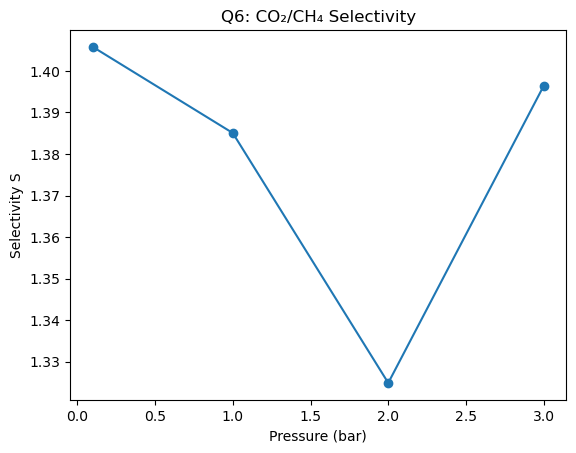

In [14]:
# Plot selectivity vs P
plt.figure()
plt.plot(df_q6["P(bar)"], df_q6["S"], marker="o")
plt.xlabel("Pressure (bar)")
plt.ylabel("Selectivity S")
plt.title("Q6: CO₂/CH₄ Selectivity")
plt.show()

**Discussion Q6**  
- S > 1: IRMOF-1 adsorbs more CO₂ than CH₄.  
- Values are ~1.3–1.4 in these files (moderate selectivity).  
- Note: provided CO₂ data is at 400 K and CH₄ at 300 K → for consistency both should be at 300 K.

# Question 7

At low P (Henry regime):
\[
q_i = K_i \, y_i \, P \quad \Rightarrow \quad S = \frac{K_{CO₂}}{K_{CH₄}}
\]
So S does not depend on composition.

We check numerically at P = 0.1 bar for two gas mixtures.


In [15]:
P_test = 0.1
for (y_CO2, y_CH4) in [(0.5,0.5),(0.2,0.8)]:
    q_co2, q_ch4, S = selectivity(P_test, y_CO2, y_CH4)
    print(f"y_CO2={y_CO2}, y_CH4={y_CH4} -> S = {S:.4f}")

print(f"S from Henry constants = {K_CO2/K_CH4:.4f}")

y_CO2=0.5, y_CH4=0.5 -> S = 1.4058
y_CO2=0.2, y_CH4=0.8 -> S = 5.6232
S from Henry constants = 1.4058


**Discussion Q7**  
- Numerical check confirms S is the same for y_CO₂ = 0.5 or 0.2 at low P.  
- Analytically, S = K_CO₂/K_CH₄, independent of composition.  
- To test temperature effect: compute isotherms at another T (e.g. 280 K, 320 K) and recalc S(T). If S changes with T, selectivity depends on temperature.

# Question 8

We examine the pure CH₄ isotherm and comment on storage potential.

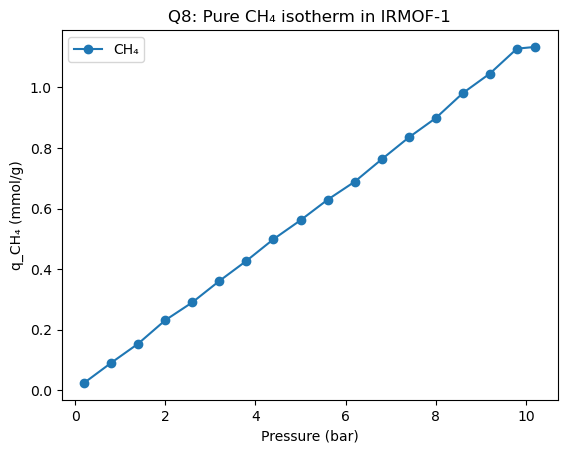

In [16]:
plt.figure()
plt.plot(pressures_ch4, loadings_ch4, marker="o", label="CH₄")
plt.xlabel("Pressure (bar)")
plt.ylabel("q_CH₄ (mmol/g)")
plt.title("Q8: Pure CH₄ isotherm in IRMOF-1")
plt.legend()
plt.show()


**Discussion Q8**  
- CH₄ uptake is modest compared to CO₂.  
- IRMOF-1 shows weak CH₄ interactions → low working capacity.  
- Therefore, IRMOF-1 is **not a good candidate** for CH₄ storage, though it works better for CO₂/CH₄ separation.